<a href="https://colab.research.google.com/github/jtsy0925uq/Lab03-demo-/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TASK 3: Burning Ship Fractal**

prompt used: Give PyTorch impementation of Burning ship fractal using tensor ops. avoid using numpy in loops if possible and include an early exit if pixels have escaped. Choose best cloloring to portray this fractal contrasting the important hull of the ship from the background.

Using: cpu


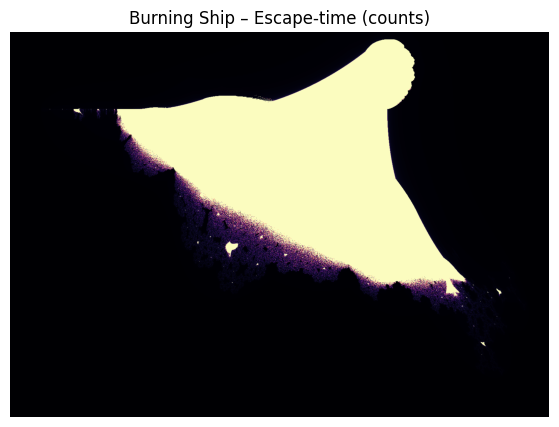

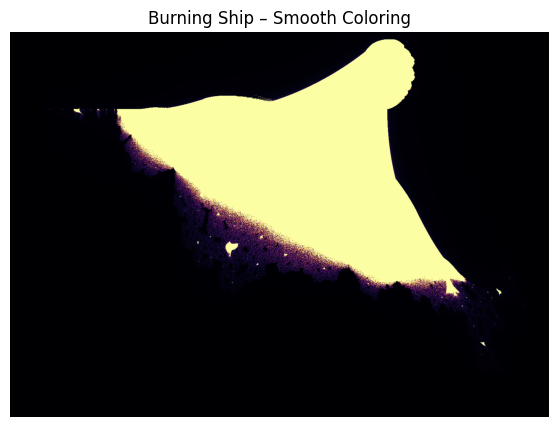

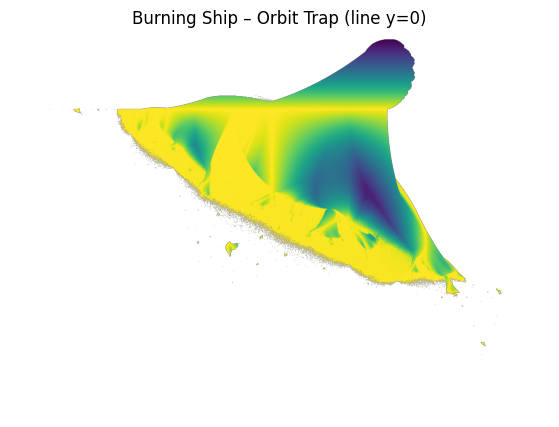

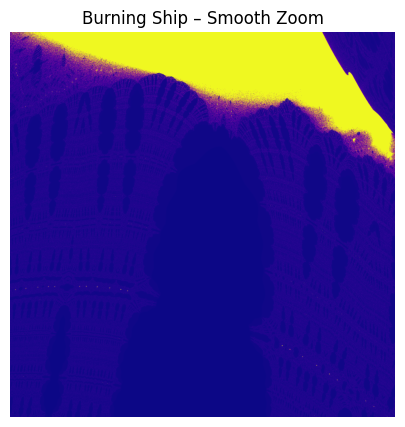

Estimated box-counting dimension of boundary: -1.644


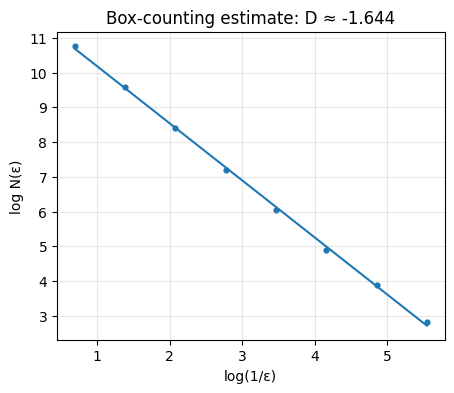

In [4]:
# Burning Ship fractal (PyTorch, GPU-ready) + smooth coloring + orbit-trap + box-counting dimension
import torch, numpy as np, matplotlib.pyplot as plt

# ---------------- Device & types ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype_c = torch.complex64  # fast & sufficient precision
print("Using:", device)

# ---------------- Utilities ----------------
def complex_grid(xmin, xmax, ymin, ymax, width, height, device=device, dtype=dtype_c):
    xs = torch.linspace(xmin, xmax, width, device=device)
    ys = torch.linspace(ymin, ymax, height, device=device)
    Y, X = torch.meshgrid(ys, xs, indexing='ij')
    return (X.to(torch.float32) + 1j * Y.to(torch.float32)).to(dtype)

@torch.inference_mode()
def burning_ship_counts(width=1400, height=1000, max_iter=10000,
                        xmin=-2.2, xmax=1.3, ymin=-2.0, ymax=0.5,
                        trap='none', trap_param=0.0, device=device):
    """
    Returns:
      counts   (H,W) int16  : escape-time iteration count (max_iter for in-set)
      smooth   (H,W) float32: continuous coloring value (NaN for unescaped)
      trap_val (H,W) float32: orbit-trap metric if enabled (else None)
    """
    C = complex_grid(xmin, xmax, ymin, ymax, width, height, device)
    Z = torch.zeros_like(C)
    counts  = torch.zeros((height, width), dtype=torch.int16, device=device)
    escaped = torch.zeros((height, width), dtype=torch.bool, device=device)
    smooth  = torch.full((height, width), float('nan'), dtype=torch.float32, device=device)

    # Orbit trap setup
    use_trap = trap != 'none'
    if use_trap:
        trap_val = torch.full((height, width), float('inf'), dtype=torch.float32, device=device)
    else:
        trap_val = None

    for i in range(max_iter):
        # Burning Ship update: z -> (|Re z| + i|Im z|)^2 + c
        Z = (torch.abs(Z.real) + 1j*torch.abs(Z.imag))**2 + C

        # magnitude^2 for escape check (avoid sqrt)
        mag2 = Z.real*Z.real + Z.imag*Z.imag

        # Smooth escape-time (only for pixels that escape now)
        just_escaped = (mag2 > 4.0) & (~escaped)
        if just_escaped.any():
            # smooth coloring: nu = n + 1 - log2(log |Z|)
            # use log(sqrt(mag2)) = 0.5*log(mag2)
            log_abs = 0.5*torch.log(mag2[just_escaped])
            nu = i + 1 - torch.log(log_abs)/torch.log(torch.tensor(2.0, device=device))
            smooth[just_escaped] = nu.float()

        counts[just_escaped] = i
        escaped |= just_escaped

        # orbit trap metrics (record minimal value along the orbit)
        if use_trap:
            if trap == 'line':        # distance to real axis (y=0)
                d = torch.abs(Z.imag)
            elif trap == 'circle':    # distance to circle of radius r0=trap_param
                r = torch.sqrt(mag2)
                d = torch.abs(r - trap_param)
            elif trap == 'point':     # distance to a point z0=trap_param (real), use |Z - z0|
                z0 = torch.complex(torch.tensor(trap_param, device=device), torch.tensor(0.0, device=device))
                d = torch.abs(Z - z0)
            else:
                d = torch.zeros_like(Z.real)
            trap_val = torch.minimum(trap_val, d.float())

        if escaped.all():
            break

    # assign max_iter to those that didn't escape (cleaner escape-time coloring)
    counts[~escaped] = max_iter
    return counts, smooth, trap_val

def show(img, extent, title, cmap='magma'):
    plt.figure(figsize=(8,5))
    plt.imshow(img, origin='lower', extent=extent, cmap=cmap)
    plt.title(title); plt.axis('off'); plt.show()

# ---------------- Render: basic escape-time ----------------
W, H, ITERS = 1600, 1100, 600
bounds = (-2.2, 1.3, -2.0, 0.5)  # (xmin, xmax, ymin, ymax)
counts, smooth, _ = burning_ship_counts(W, H, ITERS, *bounds)

show(counts.detach().cpu().numpy(), bounds, "Burning Ship – Escape-time (counts)", cmap='magma')

# ---------------- Render: smooth coloring ----------------
# Replace NaNs (unescaped) with max_iter for a continuous look; tweak gamma for contrast
smooth_img = smooth.detach().cpu().numpy()
smooth_img = np.nan_to_num(smooth_img, nan=float(ITERS))
show(smooth_img, bounds, "Burning Ship – Smooth Coloring", cmap='inferno')

# ---------------- Render: orbit-trap coloring (distance to real axis) ----------------
counts2, _, trap_line = burning_ship_counts(W, H, ITERS, *bounds, trap='line')
trap_img = trap_line.detach().cpu().numpy()
# Invert & normalize for nicer contrast
trap_img = 1.0 / (1.0 + trap_img)
show(trap_img, bounds, "Burning Ship – Orbit Trap (line y=0)", cmap='viridis')

# ---------------- Optional: a zoom (change center/half-widths to taste) ----------------
cx, cy = -1.758, -0.035
hx, hy = 0.02, 0.02
zoom_bounds = (cx - hx, cx + hx, cy - hy, cy + hy)
counts_z, smooth_z, _ = burning_ship_counts(2200, 1500, 1200, *zoom_bounds)
show(np.nan_to_num(smooth_z.detach().cpu().numpy(), nan=1200), zoom_bounds,
     "Burning Ship – Smooth Zoom", cmap='plasma')

# ---------------- Fractal dimension (box-counting) of boundary ----------------
def boundary_mask_from_counts(counts_t):
    """Approx boundary: points that are neither deep interior nor immediately escaped,
       and have a neighbor with different count (edge)."""
    c = counts_t
    H, W = c.shape
    # 4-neighbor differences
    up = torch.zeros_like(c); up[1:] = (c[1:] != c[:-1])
    dn = torch.zeros_like(c); dn[:-1] = (c[:-1] != c[1:])
    lf = torch.zeros_like(c); lf[:,1:] = (c[:,1:] != c[:,:-1])
    rt = torch.zeros_like(c); rt[:,:-1] = (c[:,:-1] != c[:,1:])
    edge = up | dn | lf | rt
    # exclude obvious interiors/exteriors if desired; keep where counts are between small and max
    interior = (c == c.max())
    exterior = (c <= 3)  # quick heuristic
    return edge & (~interior) & (~exterior)

def box_count_dimension(mask_np):
    """Estimate fractal dimension via box counting with powers of two box sizes."""
    h, w = mask_np.shape
    # choose box sizes as powers of two up to min(h,w)
    max_pow = int(np.floor(np.log2(min(h, w))))
    sizes = [2**k for k in range(1, max_pow-1)]  # avoid extremes
    eps, N = [], []
    for s in sizes:
        hh = (h // s) * s
        ww = (w // s) * s
        m = mask_np[:hh, :ww]
        # reshape into blocks of size s x s, count non-empty blocks
        m4 = m.reshape(hh//s, s, ww//s, s)
        blocks = m4.any(axis=(1,3))
        nboxes = np.count_nonzero(blocks)
        if nboxes > 0:
            eps.append(1.0/s)
            N.append(nboxes)
    eps = np.array(eps); N = np.array(N)
    # linear fit: log N = D * log(1/eps) + b
    x = np.log(1.0/eps); y = np.log(N + 1e-12)
    D, b = np.polyfit(x, y, 1)
    return D, (x, y)

# Build boundary mask at decent resolution
counts_for_dim, _, _ = burning_ship_counts(1536, 1024, 800, *bounds)
mask = boundary_mask_from_counts(counts_for_dim).detach().cpu().numpy().astype(bool)
D, (x, y) = box_count_dimension(mask)
print(f"Estimated box-counting dimension of boundary: {D:.3f}")

# Plot regression
plt.figure(figsize=(5,4))
plt.scatter(x, y, s=12)
m, c0 = np.polyfit(x, y, 1)
xx = np.linspace(x.min(), x.max(), 200)
plt.plot(xx, m*xx + c0)
plt.xlabel("log(1/ε)")
plt.ylabel("log N(ε)")
plt.title(f"Box-counting estimate: D ≈ {D:.3f}")
plt.grid(True, alpha=0.3)
plt.show()


# **Second Try to get a better visual of the "Burning Ship"**

Prompt used: The earlier output does not represent the burning ship nicely, eg, i dont see the shape of the ship and the inner color is too bright to discern nice looking patterns. give me a varation of common presets used for the bounds for the complex plane.

In [9]:
import torch, numpy as np, matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using:", device)

def complex_grid(xmin, xmax, ymin, ymax, width, height, device, dtype=torch.complex64):
    xs = torch.linspace(xmin, xmax, width, device=device)
    ys = torch.linspace(ymin, ymax, height, device=device)
    Y, X = torch.meshgrid(ys, xs, indexing='ij')
    return (X.to(torch.float32) + 1j*Y.to(torch.float32)).to(dtype)

@torch.inference_mode()
def burning_ship(width, height, max_iter, xmin, xmax, ymin, ymax, device=device):
    C = complex_grid(xmin, xmax, ymin, ymax, width, height, device)
    Z = torch.zeros_like(C)
    counts  = torch.zeros((height, width), dtype=torch.int16, device=device)
    smooth  = torch.full((height, width), float('nan'), dtype=torch.float32, device=device)
    escaped = torch.zeros((height, width), dtype=torch.bool, device=device)
    ln2 = torch.log(torch.tensor(2.0, device=device))

    for i in range(max_iter):
        Z = (torch.abs(Z.real) + 1j*torch.abs(Z.imag))**2 + C
        mag2 = Z.real*Z.real + Z.imag*Z.imag
        just_escaped = (mag2 > 4.0) & (~escaped)
        if just_escaped.any():
            log_abs = 0.5*torch.log(mag2[just_escaped])  # ln|Z|
            nu = i + 1 - torch.log(log_abs)/ln2
            smooth[just_escaped] = nu.float()
        counts[just_escaped] = i
        escaped |= just_escaped
        if escaped.all(): break

    counts[~escaped] = max_iter
    return counts, smooth

def show_smooth_stretched(smooth, extent, max_iter, cmap='turbo', interior='black'):
    """Percentile stretch + choose interior color so the silhouette reads clearly."""
    s = smooth.detach().cpu().numpy()
    mask = np.isfinite(s)                     # escaped pixels only
    # Robust contrast: ignore 1% darkest/brightest
    lo, hi = np.percentile(s[mask], (1, 99)) if mask.any() else (0, 1)
    s = np.clip((s - lo) / max(hi - lo, 1e-6), 0, 1)
    if interior == 'black':
        s[~mask] = 0.0
    else:
        s[~mask] = 1.0
    plt.figure(figsize=(9,6))
    plt.imshow(s, origin='lower', extent=extent, cmap=cmap)
    plt.title("Burning Ship — Contrast-stretched smooth coloring")
    plt.axis('off'); plt.colorbar(shrink=0.75)
    plt.show()

def show_counts_log(counts, extent, max_iter, cmap='magma'):
    c = counts.detach().cpu().numpy().astype(np.float32)
    c = np.log1p(c) / np.log1p(max_iter)      # log compress bands
    plt.figure(figsize=(9,6))
    plt.imshow(c, origin='lower', extent=extent, cmap=cmap)
    plt.title("Burning Ship — Log escape-time")
    plt.axis('off'); plt.colorbar(shrink=0.75)
    plt.show()


Using: cpu


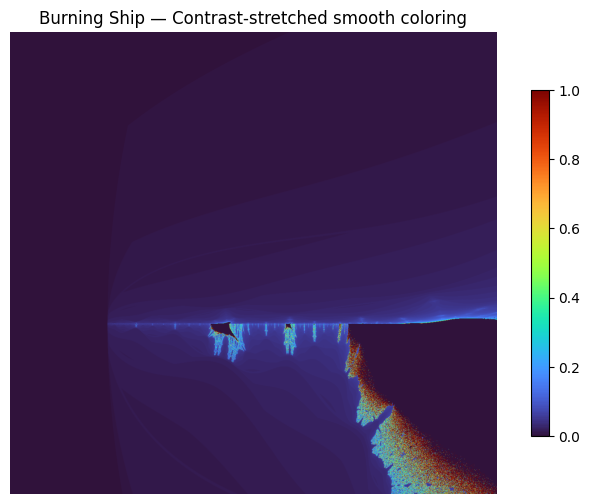

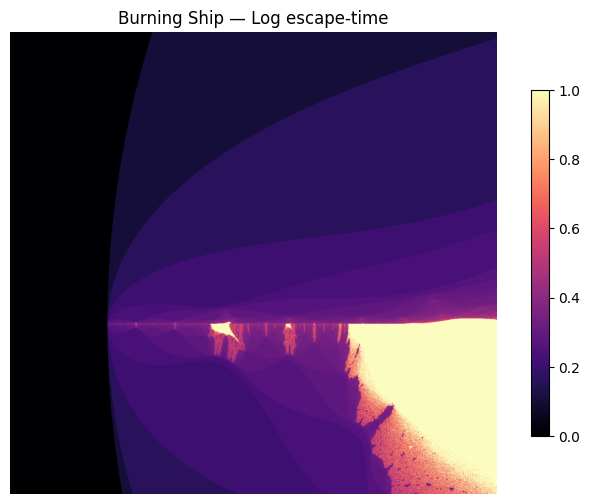

In [10]:
# Classic ship framing (zoomed out enough to see the hull + prow + plume)
bounds = (-2.2, -1.2, -0.35, 0.60)   # xmin, xmax, ymin, ymax  ← key change
W, H, ITERS = 2000, 1300, 900

counts, smooth = burning_ship(W, H, ITERS, *bounds, device=device)

# Two complementary views:
show_smooth_stretched(smooth, bounds, ITERS, cmap='turbo', interior='black')
show_counts_log(counts, bounds, ITERS, cmap='magma')


presets

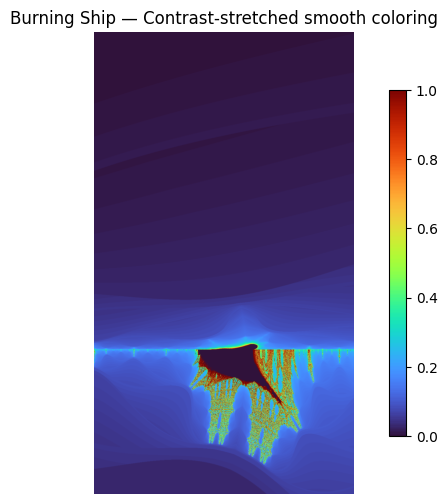

In [13]:
presets = {
    "Wider (more context)":   (-2.25, -1.10, -0.50, 0.70),
    "Tighter on hull":        (-1.95, -1.55, -0.25, 0.25),
    "Prow focus":             (-1.86, -1.68, -0.10, 0.22),
}

name = "Prow focus"   # change this to try others
xmin, xmax, ymin, ymax = presets[name]
counts2, smooth2 = burning_ship(2200, 1500, 1200, xmin, xmax, ymin, ymax, device=device)
show_smooth_stretched(smooth2, (xmin, xmax, ymin, ymax), 1200, cmap='turbo', interior='black')
